# Imports


In [13]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
import math
import time
from fake_useragent import UserAgent
import validators
import matplotlib.pyplot as plt

In [192]:
%run library.ipynb

# Load in Existing Dataset:

In [125]:
scraped_data = pd.read_csv("scraped_data_old.csv")
scraped_data.set_index(list(scraped_data.columns)[0], inplace=True)

In [3]:
# just scrape wild turkey
# adjusted by mean price increase from last auction
# basket of bourbons, scotches, japanese - look for differences in pricing


# OG Scraping

In [38]:
lots_dict = {}
categories = ['Distillery', 'Age', 'Vintage', 'Region', 'Bottler', 'Cask Type', 'Bottled Strength', 'Bottle Size',
             'Distillery Status']
ua = UserAgent()
date_format = "%d.%m.%y"
per_page = 40


In [81]:
date_format = "%y.%d.%m"

In [39]:
def og_scraper():
    '''Scrapes data from Whiskey Auctioneer and saves to dictionary'''
    
    # more_new_data = True

    # URL of the first page of results
    url_stem = "https://whiskyauctioneer.com/auction-search"
    
    url = True
    
    try:
        live_url = "https://whiskyauctioneer.com/current-auction"
        page = requests.get(live_url, headers={'user-agent': ua.random})
        soup = BeautifulSoup(page.content, "html.parser")
        start_page = math.floor(int(re.findall(r'\d+', soup.find("p", class_ = "left").text)[0]) / per_page)-1
        i = start_page
        
    except:
        #i = 0
        i = 369
    
    # Loop through remaining pages until you get to where there aren't any more
    while url:
        
        if i == 0:
            url = url_stem
        else:
            url = url_stem + f'?page={i}'

        page = requests.get(url, headers={'user-agent': ua.random})
        soup = BeautifulSoup(page.content, "html.parser")
        
        result_1 = soup.find("div", class_ ="views-row views-row-1 views-row-odd views-row-first producthomepage")
        result = result_1
        
        # Now we need to iterate through the lots on the page
        while result != None:

            lot_dict = {}
            
            lot_num = int(re.findall(r'\d+', result.find("span", class_ = "lotnumber label-lot").text)[0])
            if lot_num in list(scraped_data.index):
                
                more_new_data = False
                result = result.nextSibling
                continue
            
            # Skip this iteration if the lot is part of a current auction:
            if "Bid Now" in result.text:
                result = result.nextSibling
                continue
                 
            lot_dict["name"] = result.find("a")["_title"]
            lot_dict["price"] = int(''.join(re.findall(r'\d+', result.find("div", class_ = "lotwin cru").text)))
            if "Reserve not met" in result.find("div", class_ = "lotwin cru").text:
                lot_dict['reserve_met'] = 0
            elif "Reserve has been met" in result.find("div", class_ = "lotwin cru").text:
                lot_dict['reserve_met'] = 1
            lot_dict['end_date'] = datetime.strptime(result.find("div", 
                                class_ = "enddatein").text.split(':')[1].strip(), date_format).date()
            lot_num = int(re.findall(r'\d+', result.find("span", class_ = "lotnumber label-lot").text)[0])
               
            # Get lot site
            lot_url = result.find("a", href=True)['href']
           
            
            lot_page = requests.get(lot_url, headers={'user-agent': ua.random})
            lot_soup = BeautifulSoup(lot_page.content, "html.parser")
            
            
            try:
                child = lot_soup.find("div", class_ = "whiskyproduct").findChild()
            except:
                print(lot_url)
                result = result.nextSibling
                continue
            # Iterate through children to get all info
            while child:
                
                for val in categories:
                    if val in child.text:
                        cat = val
                        
                value = str(child.text).replace("\xa0", '').split(':')[1]
                
                lot_dict[cat] = value
                
                child = child.nextSibling
                
            prod_details = lot_soup.find("div", {"class": "field-item even", 
                                                 "property": "content:encoded"}).text.replace("\xa0", '')
            
            lot_dict['details'] = prod_details
                
            lots_dict[lot_num] = lot_dict
            
            # This iterates the loop to the next lot
            result = result.nextSibling
            
            time.sleep(3)
        
        print(f"Done page {i}")
        i += 1
        time.sleep(3)
         
        
    return lots_dict
        

In [40]:
#og_scraper()

In [36]:
scraped_data_cur = pd.DataFrame.from_dict(lots_dict, orient = "index")
scraped_data = pd.concat([scraped_data, scraped_data_cur])
# REMEMBER TO RESET START NUMBER AND CLEAR LOTS DICT

In [37]:
scraped_data.to_csv("scraped_data.csv")

# Iterative Scraping

In [281]:
def scraper():
    '''Scrapes data from Whiskey Auctioneer and saves to dictionary'''
    
    more_new_data = True

    # URL of the first page of results
    url_stem = "https://whiskyauctioneer.com/auction-search"
    
    url = True
    
    live_url = "https://whiskyauctioneer.com/current-auction"
    page = requests.get(live_url, headers=headers)
    soup = BeautifulSoup(page.content, "html.parser")
    start_page = math.floor(int(re.findall(r'\d+', soup.find("p", class_ = "left").text)[0]) / per_page)-1
    
    i = start_page
    #i = 209
    
    # Loop through remaining pages until you get to where there aren't any more
    while url and more_new_data:
        print(i)
        
        if i == 0:
            url = url_stem
        else:
            url = url_stem + f'?page={i}'

        page = requests.get(url, headers=headers)
        soup = BeautifulSoup(page.content, "html.parser")
        
        result_1 = soup.find("div", class_ ="views-row views-row-1 views-row-odd views-row-first producthomepage")
        result = result_1
        # Now we need to iterate through the lots on the page
        while result and more_new_data:
            lot_dict = {}
            
            lot_num = int(re.findall(r'\d+', result.find("span", class_ = "lotnumber label-lot").text)[0])
            if lot_num in list(scraped_data.index):
                more_new_data = False
            
            # Skip this iteration if the lot is part of a current auction:
            if "Bid Now" in result.text:
                result = result.nextSibling
                continue
                 
            lot_dict["name"] = result.find("a")["_title"]
            lot_dict["price"] = int(''.join(re.findall(r'\d+', result.find("div", class_ = "lotwin cru").text)))
            lot_dict['reserve_met'] = 1 if "Reserve not met" in result.find("div", class_ = "lotwin cru").text else 0
            lot_dict['end_date'] = datetime.strptime(result.find("div", 
                                class_ = "enddatein").text.split(':')[1].strip(), date_format).date()
            lot_num = int(re.findall(r'\d+', result.find("span", class_ = "lotnumber label-lot").text)[0])
               
            # Get lot site
            lot_url = result.find("a", href=True)['href']
            
            lot_page = requests.get(lot_url, headers=headers)
            lot_soup = BeautifulSoup(lot_page.content, "html.parser")
            
            child = lot_soup.find("div", class_ = "whiskyproduct").findChild()
            # Iterate through children to get all info
            while child:
                
                for val in categories:
                    if val in child.text:
                        cat = val
                        
                value = str(child.text).replace("\xa0", '').split(':')[1]
                
                lot_dict[cat] = value
                
                child = child.nextSibling
                
            prod_details = lot_soup.find("div", {"class": "field-item even", 
                                                 "property": "content:encoded"}).text.replace("\xa0", '')
            
            lot_dict['details'] = prod_details
                
            lots_dict[lot_num] = lot_dict
            
            # This iterates the loop to the next lot
            result = result.nextSibling
        
        i += 1
        time.sleep(3)
         
        
    return lots_dict
        

In [284]:
#scraper()

In [277]:
scraped_data = pd.DataFrame.from_dict(lots_dict, orient = "index")
scraped_data.to_csv("scraped_data.csv")

# Data Cleaning

In [194]:
scraped_data_clean = scraped_data.copy()

scraped_data_clean['end_date'] = pd.to_datetime(scraped_data['end_date'], format='%Y-%d-%m')

scraped_data_clean['Age'] = scraped_data['Age'].apply(clean_age)

scraped_data_clean['name'] = [i.lower() for i in scraped_data['name']]

scraped_data_clean.Distillery = scraped_data.Distillery.apply(try_lower)

# Output

In [195]:
scraped_data_clean.Distillery

Unnamed: 0
6182043         caol ila
6182044         midleton
6182045             yuza
5119084       port ellen
6182046    bruichladdich
               ...      
7001235          nc'nean
5113680         macallan
7001291          nc'nean
5116933          nc'nean
5118056              NaN
Name: Distillery, Length: 14416, dtype: object

In [198]:
search_df = scraped_data_clean.copy()

search_term = input("What are you looking for?")
search_df = search_df[search_df['name'].str.contains(search_term.lower())]

year = input(f"Any particular year? Year Options: {list(search_df['Age'].value_counts().index)} or type 'NO'")
if year != "NO":
    search_df = search_df[search_df['Age']==year]
    
distillery = input(f"Any particular distillery? Options: {list(search_df['Distillery'].value_counts().index)} or type 'NO'")
search_df = search_df[search_df['name'].str.contains(distillery.lower())]

What are you looking for? pappy van winkle
Any particular year? Year Options: ['15', '20', '23', '12'] or type 'NO' 12
Any particular distillery? Options: ['buffalo trace'] or type 'NO' buffalo trace


In [76]:
cur_price = int(input("What current price are you looking at?"))

What current price are you looking at? 2000


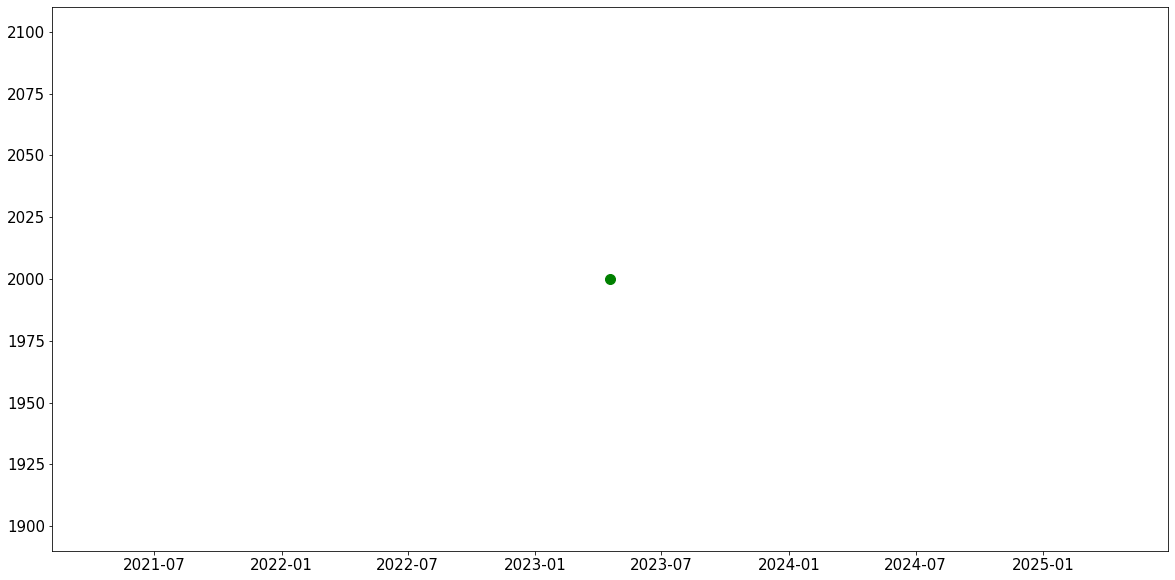

In [199]:
search_df_means = search_df[['price', 'end_date']].groupby("end_date").mean()

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(search_df['end_date'], search_df['price'], s=100)
ax.scatter(search_df_means.index, search_df_means['price'], color = "red", s = 100)
ax.plot(search_df_means.index, search_df_means['price'], color = "red", linewidth = 5)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.scatter(pd.to_datetime(datetime.today().strftime('%Y-%m-%d')), cur_price, s=100, color = "green");

In [ ]:
# expression = distillery (ex = Wild Turkey), age, proof, vintage (year), 
# uniquely identify each expression and track price over time
# only care about 